# Notifiers

## Untangling GUIs with Model-View-Controller

As we build larger projects, it becomes more and more important to divide them into parts, and to control the ways in which one part depends on another. We must do this not only at the level of individual functions and classes, but also at the coarser grain level of modules in separate files.

A particular case where we often need to divide a program into coarse-grain modules is applications with graphical user interfaces. Suppose, for example, that we are building an application that we want to run on MacOS, Linux, and Windows, or on Android and iPhone: There are some parts that will need to be specialized for each platform, and (hopefully) some parts that can be almost or fully independent of the platform. We don’t want to jumble those parts all up in the same source files!

### Typically we might want at least three different files, or sets of files:

 - The graphics interaction component. This part would handle basic graphical interaction tasks like drawing a shape on the screen and determining which shape a user touched or clicked. It might contain classes like “Box” and “Menu”, and we might be able to reuse it for several different interactive programs. It might depend on a specific platform (say, Cocoa under MacOS or the equivalent Windows toolkit), and thus for a multi-platform application we might need more than one version of the graphics component.

 - Application logic, often called the model component. If our application is for pizza design, this is the component that knows that pineapple should never be added to pizza. As much as possible, we would like this component to be independent of the graphical interaction, and reusable across platforms.

 - Interaction logic, often called the view component. This is the part that knows that a pizza is round and that tomato sauce is red. It does not know much about pizzas and it does not know how the graphics component draws a circle, but it knows that it should draw circles of different sizes to indicate possible pizza sizes, and that when the user clicks on the middle circle it indicates a choice of a medium size pizza.

As soon as we start to sketch out the relations among these modules, we see a potential problem. 
 - The relation between the view module and graphics is fine: The view module will need to import the graphics module to gain access to functions and classes for drawing pizzas. 
 - But what about the relation between the view module and the model (pizza) module? Should the view module import the model module, or vice versa? 
 - We want the graphical depiction to be updated when the pizza changes, so it seems like the model needs access to the view to trigger updates. 
 - But when the user clicks the picture of a medium size pizza, it seems like the view needs access to the model to set pizza size to medium. Each component seems to depend on the other.

We need to break this circular dependence between model and view. There is a common, fairly standard way to break it, called the **model-view-controller** design pattern.

## Notifiers

Functions or methods in the view component need to call methods or functions in the model component when the user interacts, e.g., by touching or clicking a shape on the screen or by pressing a key on the keyboard. 

The model component will then do something and call methods or functions in the view component to indicate that some parts of screen representation should be updated. Thus parts of each module call parts in the other module.

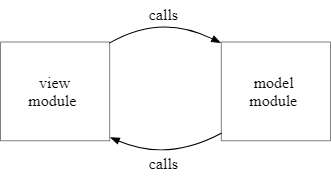

Calls between the two components is not a problem in itself, unless there is an infinite recursive loop. We can avoid that easily enough. The problem is that each needs to “see” the methods or functions in the other, which typically means each module needs to import the other. We need to break the import cycle.

It is possible for functions or methods in module to call the other without importing that module. The trick involves inheritance and an abstract Listener class.

Let’s suppose we want a method in class M to call a method in class V, and a method in class V to call a different method in class M. Note that this may not be recursive at all: M.f calls V.g, and V.g calls M.h; there is a cycle among the objects but not among the methods.

In [3]:
class M:
    def __init__(self):
        self.the_V = None

    def hook_up(self, v: 'V'):
        self.the_V = v

    def f(self):
        self.the_V.g(self)

    def h(self):
        print("What goes around, comes around")

class V:
    def __init__(self):
        pass

    def g(self, an_m: M):
        an_m.h()

v = V()
m = M()
m.hook_up(v)
m.f()

What goes around, comes around


If we place M and V in different modules, each module will have to import the other.

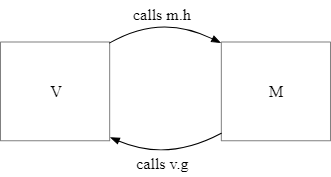

We can’t break the cycle in calls (and we don’t want to), but we can break the cycle in import by interposing a third module with abstract base classes. We can think of the abstract base classes as defining some wires that can be connected in the concrete classes.

In [4]:
class Listener:
    """Abstract base class for classes in View component"""
    def notify(self, event: str):
        raise NotImplementedError("Notify has not been implemented")

class ModelElement:
    """Abstract base class for classes in Model component"""

    def __init__(self):
        self.listeners = []

    def add_listener(self, listener: Listener):
        self.listeners.append(listener)

    def notify_all(self, event: str):
        for listener in self.listeners:
            listener.notify(self, event)


class M(ModelElement):

    def __init__(self):
        super().__init__()
        # Might have more of its own initialization here

    def f(self):
        # Instead of self.the_V.g()
        self.notify_all("g")

    def h(self):
        print("What goes around, comes around")


class V(Listener):
    def __init__(self):
        pass

    def notify(self, an_m: M, event: str):
        # Instead of a call to method g, we
        # might get an event "g"
        if event == "g":
            an_m.h()

The revised version is more complex, but it essentially duplicates the calling relation between methods in M and V from above. There are a couple of differences: Instead of the M object having a reference to exactly one V element, it can be hooked to zero or more V elements (the listeners list). Instead of calling V.g, it now notifies the V object of a g event (and now the V object must interpret the event in its notify method). Overall, though, the behavior is the same:

In [5]:
v = V()
m = M()
m.add_listener(v)
m.f()

What goes around, comes around


What we have gained from this indirect calling arrangement is the ability to divide the code into three modules, with no cycles in the import relation:

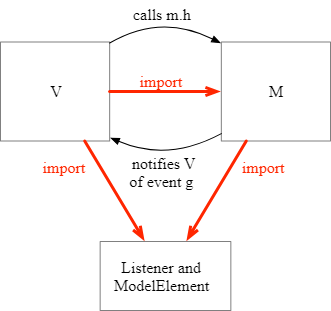


# Model - View- Controller (MVC)

 - Structures like that described above, with “event notification” taking the place of some direct method calls, are common in object-oriented programs. They are used for many purposes besides graphical interaction, but their use in interactive programs is so common that the pattern has a name: Model-View-Controller, often abbreviated to MVC.

 - In the MVC structure (also called a design pattern), the application logic is in the model component. The model component calls its notify_all method with each event that may be significant to the interaction, but (as far as possible) is not concerned with details of the interaction. The view component comprises a set of listeners that interpret and act on events. View classes may also make calls on objects in the model, for example to replace tomato sauce with pesto. (Thus the view is dependent on the model, but the model is independent of the view.) The view component also makes calls on the graphics component, isolating it from the model component. (Thus MVC makes it much easier to build a multi-platform interactive application, or to switch between graphical toolkits.)

 - Although the MVC pattern is very common, there are many variations. In our example above, we used strings to represent events. We could have used an Enum class, or created an Event class with a subclass for each kind of event. The possible events, and the information that must be conveyed along with each event, vary widely from application to application. The pattern is fairly easy to spot, and the method names add_listener, notify, and notify_all are fairly standard, but you will still need to read the code fairly carefully to understand all the details.

# Summary
- Large programs must be broken into parts (modules) that we can work on separately. 
- When we work as a team, we want each developer to be able to work on their own module as independently as possible. 
- We also want to be able to test and debug one module without understanding all the other modules, and ideally we would like to be able to reuse some modules and to replace one module entirely without changing others (e.g., replacing a view component that uses one graphics library with a view component that uses a different graphics library).

- Model-View-Controller is a design pattern that allows us to achieve that modularity for interactive applications.
- One of more modules in the model component are responsible for application logic, and for creating events that may be relevant to the view component. The view component is responsible for interaction, and isolates the model from the graphics library.
- Abstract base classes for the model and view components can be placed in a separate module, breaking what would otherwise be a cycle in the import relation.

# Project
- The FiveTwelve <https://github.com/UO-CIS211/FiveTwelve> game, a simplified version of 2048, which was based on 1024, which was in turn inspired by the more challenging sliding tile game Threes, uses subclasses and inheritance to combine graphical interaction coded in a view component with game logic coded in a model component.